To use this notebook, use classical3D.zip or jazz3D.zip, obtained with the preprocessing file

# Import and dataprocessing


In [ ]:
!pip install pretty_midi

     |████████████████████████████████| 5.6MB 3.4MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp37-none-any.whl size=5591954 sha256=4c55caecee8c5c51d4491d599c1a7fa180eef1a1cb0f7ff5a22802d995395f83
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pretty-midi


In [ ]:
import random
import os
import pretty_midi
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset

import random as rd
import copy

# we use GPU if available, otherwise CPU
device_to_use = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_to_use)
print(f"Using {device_to_use} device")


Using cuda:0 device


In [ ]:
!unzip "classical3D.zip"

In [ ]:
!unzip "jazz3D.zip"

In [ ]:
def get_samples(style="J", length=64, n=1000, random=False, min_note_per_sample=100):
    """Return the preprocessed samples

    Parameters
    ----------
    style : str, optional
        Style of the music, one of {"J", "C"} (for "Jazz" and "Classic"), by default "J"
    length : int, optional
        The length in time steps of each samples
    n : int, optional
        Number of samples which will be returned, by default 100
    random : bool, optional
        Whether to randomize the samples or not, by default False

    Returns
    -------
    List (of Numpy arrays)
        List of samples
    """

    folder = ""
    if style == "J":
      folder = "content/jazz3D"
    
    elif style == "C":
      folder = "content/classical3D"

    else:
      raise Exception("'style' must be one of {'J', 'C'}")
   
      
    list_filenames = os.listdir(folder)
    nb_samples_per_file = max(int(n/len(list_filenames)), 1)

    samples = []
    for filename in list_filenames:
      if filename[-3:] =="npy":
         
          
        filepath = folder + "/" + filename
        

        all_file = np.load(filepath).astype(int)
        all_file_size = len(all_file)

        for k in range(nb_samples_per_file):
          first_index = rd.randint(0, int((all_file_size-length-1)/4))
          sample = all_file[4*first_index:4*first_index+length,:,0:2]
          while sample.sum() < min_note_per_sample:
            first_index = rd.randint(0, int((all_file_size-length-1)/4))
            sample = all_file[4*first_index:4*first_index+length,:,0:2]


          samples.append(sample.reshape((1, 64 , 84, 2)))
          
    return np.vstack(samples)




# Creation of the model


In [ ]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, batch_size))
    return n

In [ ]:
latent_dim = 100

class CNNGenerator_3D(nn.Module):
    def __init__(self, deepth):
        super(CNNGenerator_3D, self).__init__()
        n_features = latent_dim
   
        # Latent vector going into a convolution
        self.convt1 =  nn.ConvTranspose3d(latent_dim, deepth*8, (1,4, 4), (1,1,1), 0, bias=False)
        self.batchnorm1 = nn.BatchNorm3d(deepth*8)

        # state size : (deepth*8, 1, 4, 4)
        self.convt2 = nn.ConvTranspose3d(deepth*8, deepth*4, (1,4,4), (1,2,2), (0,1,1), bias=False)
        self.batchnorm2 = nn.BatchNorm3d(deepth*4)

        #state size : (deepth*4,1, 8, 8)
        self.convt3 = nn.ConvTranspose3d(deepth*4, deepth*2, (1,4,2),(1,2,3), (0,1,1),bias=False)
        self.batchnorm3 = nn.BatchNorm3d(deepth*2)

        #state size : (deepth*2,1, 16, 21)
        self.convt4 = nn.ConvTranspose3d(deepth*2, deepth, (1,4,4),(1,2,2), (0,1,1),bias=False)
        self.batchnorm4 = nn.BatchNorm3d(deepth)

        #state size : (deepth,1 32, 42)
        self.convt5 = nn.ConvTranspose3d(deepth,1, (2,4,4),(1,2,2), (0,1,1),bias=False)

    def forward(self, x):
        x = self.convt1(x)
        x = self.batchnorm1(x)
        x = F.leaky_relu(x)
        x = self.convt2(x)
        x = self.batchnorm2(x)
        x = F.leaky_relu(x)
        x = self.convt3(x)
        x = self.batchnorm3(x)
        x = F.leaky_relu(x)
        x = self.convt4(x)
        x = self.batchnorm4(x)
        x = F.leaky_relu(x)
        x = self.convt5(x)
        x = F.sigmoid(x)
        return x

In [ ]:
class CNNDiscriminator3D(nn.Module):
    def __init__(self):
        super(CNNDiscriminator3D, self).__init__()

        self.conv_1 = nn.Conv3d(in_channels=1,out_channels=32,kernel_size=(1,2,2), stride=(1,2,2))
        self.drop1 = nn.Dropout(0.3)

        # state_size (32,2,32,42)
        self.conv_2 = nn.Conv3d(in_channels=32,out_channels=64,kernel_size=(1,2,2), stride=(1,2,2))
        self.drop2 = nn.Dropout(0.3)

        # state_size (64,2,16,21)
        self.conv_3 = nn.Conv3d(in_channels=64,out_channels=128,kernel_size=(2,16,21), stride=(1,1,1))
        self.drop3 = nn.Dropout(0.3)

        self.fc_out = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.drop1(x)
        x = F.relu(x)
        x = self.conv_2(x)
        x = self.drop2(x)
        x = F.relu(x)
        x = self.conv_3(x)
        x = self.drop3(x)
        x = F.relu(x)
        x = x.view(x.size()[0],128)
        x = F.sigmoid(self.fc_out(x))
        return x

    def load(self, backup):
        for m_from, m_to in zip(backup.modules(), self.modules()):
             if isinstance(m_to, nn.Linear) or isinstance(m_to, nn.Conv3d):
                m_to.weight.data = m_from.weight.data.clone()
                if m_to.bias is not None:
                    m_to.bias.data = m_from.bias.data.clone()

In [ ]:
def get_dist_matrix(numpy_array_data):
  dist = 0
  counter = 0
  for i in range(len(numpy_array_data)):
    matrix_i = numpy_array_data[i]
    for j in range(i+1, len(numpy_array_data)):
      matrix_j = numpy_array_data[j]
      counter+=1

      dist += np.abs(matrix_i-matrix_j).sum()
  
  return dist/counter


# Training

In [ ]:
n = 20000
batch_size = 16
data = get_samples(style="J", n=n, random=True)
dataset = TensorDataset(torch.Tensor(data).type(torch.float), torch.Tensor(np.ones((data.shape[0], 1))).type(torch.int64))
loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=batch_size)

In [ ]:
sns.displot(data[:,:,:,0].flatten(), kind="kde")
sns.displot(data[:,:,:,1].flatten(), kind="kde")

In [ ]:
n_epochs = 300

G = CNNGenerator_3D(16).to(device)
D = CNNDiscriminator3D().to(device)

loss = nn.BCELoss()
d_optimizer = optim.SGD(D.parameters(), lr=1e-3, momentum=0.5)
# g_optimizer = optim.SGD(G.parameters(), lr=1e-3, momentum=0.5)
g_optimizer = optim.Adam(G.parameters(), lr=1e-3)

In [ ]:
nb_landmark_seeds = 10
landmark_seeds = Variable(torch.FloatTensor(torch.randn(nb_landmark_seeds, latent_dim))).view(nb_landmark_seeds,latent_dim, 1,1,1 )

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0: D (0.6786 real_err, 0.6804 fake_err) G (0.6896 err) 
Generated data: 
Min value: 6.342003338504279e-15 / Max value: 0.9999809265136719
Note played simultaneously for generated data : layer 0 mean/var: 0.06 / 0.00 layer 1 mean/var : 1.64 / 0.03 


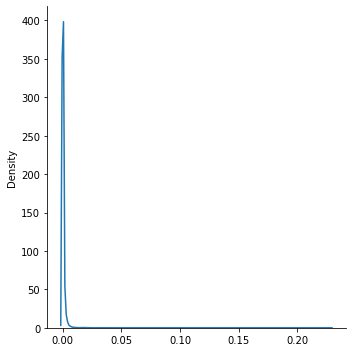

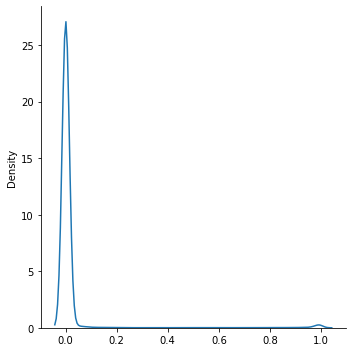

Differences between generated data : 24.80184653600057


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 5: D (0.4288 real_err, 0.3669 fake_err) G (1.4982 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data : layer 0 mean/var: 0.01 / 0.00 layer 1 mean/var : 3.42 / 2.46 
Epoch 10: D (0.4166 real_err, 0.2347 fake_err) G (1.7075 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data : layer 0 mean/var: 0.51 / 0.08 layer 1 mean/var : 1.43 / 0.25 


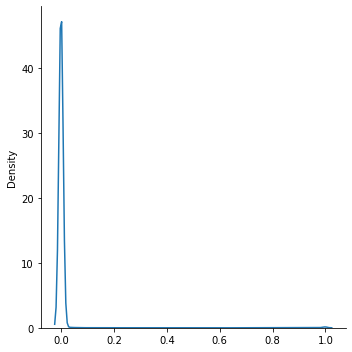

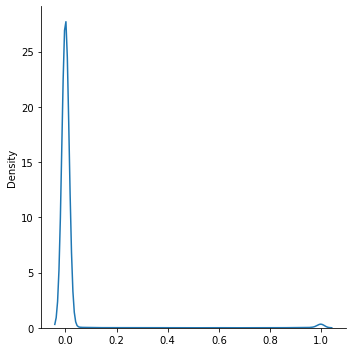

Differences between generated data : 218.45520765516494


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 15: D (0.3911 real_err, 0.3729 fake_err) G (1.6751 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data : layer 0 mean/var: 0.75 / 0.04 layer 1 mean/var : 1.71 / 0.64 
Epoch 20: D (0.6029 real_err, 0.3000 fake_err) G (1.8812 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data : layer 0 mean/var: 0.86 / 0.06 layer 1 mean/var : 1.73 / 0.52 


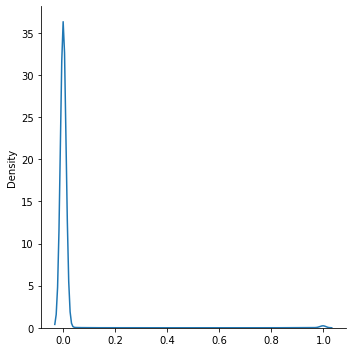

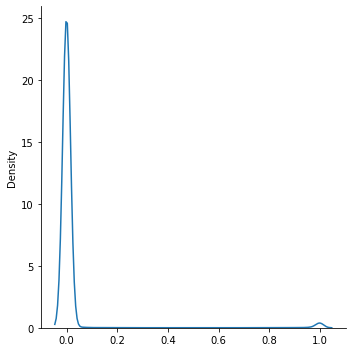

Differences between generated data : 315.1791751437717


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 25: D (0.3592 real_err, 0.2883 fake_err) G (3.3327 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data : layer 0 mean/var: 0.83 / 0.03 layer 1 mean/var : 1.40 / 0.39 
Epoch 30: D (0.2505 real_err, 0.0923 fake_err) G (2.0065 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data : layer 0 mean/var: 0.96 / 0.10 layer 1 mean/var : 1.81 / 0.50 


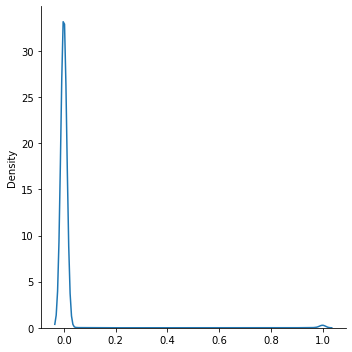

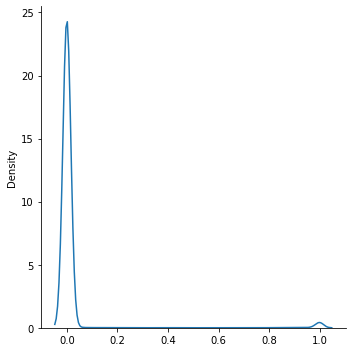

Differences between generated data : 335.73625318739147


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 35: D (0.3703 real_err, 0.1240 fake_err) G (2.3967 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data : layer 0 mean/var: 0.86 / 0.02 layer 1 mean/var : 1.76 / 0.19 
Epoch 40: D (0.1866 real_err, 0.5133 fake_err) G (3.0801 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data : layer 0 mean/var: 1.00 / 0.02 layer 1 mean/var : 1.95 / 0.45 


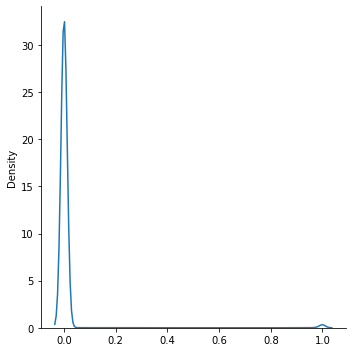

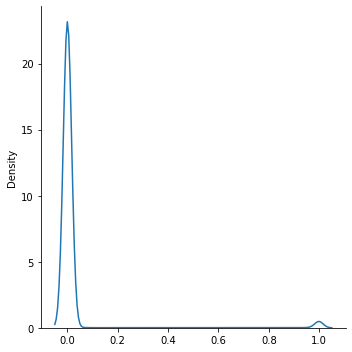

Differences between generated data : 350.94398498535156


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 45: D (0.0155 real_err, 0.9778 fake_err) G (5.1971 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data : layer 0 mean/var: 1.02 / 0.05 layer 1 mean/var : 1.69 / 0.50 
Epoch 50: D (0.1743 real_err, 0.0785 fake_err) G (3.6217 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data : layer 0 mean/var: 0.92 / 0.04 layer 1 mean/var : 1.73 / 0.43 


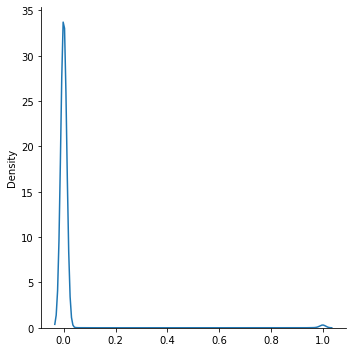

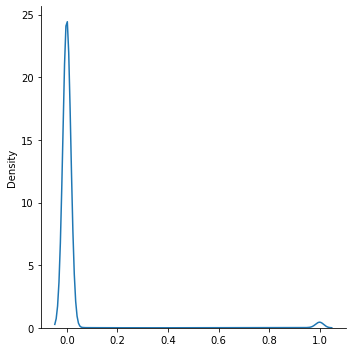

Differences between generated data : 321.9556983100043


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 55: D (0.0972 real_err, 0.0839 fake_err) G (3.2782 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data : layer 0 mean/var: 0.94 / 0.06 layer 1 mean/var : 1.81 / 0.46 
Epoch 60: D (0.2368 real_err, 0.1604 fake_err) G (4.4835 err) 
Generated data: 
Min value: 0.0 / Max value: 1.0
Note played simultaneously for generated data : layer 0 mean/var: 0.95 / 0.06 layer 1 mean/var : 1.95 / 0.44 


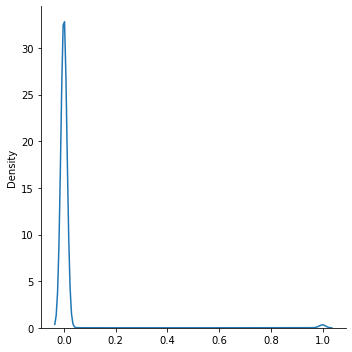

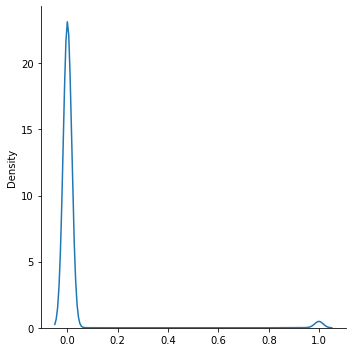

Differences between generated data : 348.8279527452257


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: ignored

In [ ]:
fake_data_list = []
landmark_seeds_data_list = []

nb_roll = 2

def extract(v):
    return v.data.storage().tolist()
epochs = []
d_fake_errs = []
d_real_errs = []
g_errs = []

# d_avg_notes = 0

for epoch in range(n_epochs):
    # for _ in range(20):  # train D for 20 steps
    for batch_idx, sample in enumerate(loader):

      ####### D_LOOP #########

    # 1. Train D on real+fake
      d_optimizer.zero_grad() 
      inputs, labels = sample
      N = len(inputs)
      inputs_real_data, labels_real_data = inputs.to(device), labels.to(device)
      inputs_real_data = inputs_real_data.permute(0,3,1,2)
      inputs_real_data = inputs_real_data.view((len(inputs),1,2,64,84))

    #  1A: Train D on real
      d_real_decision = D(inputs_real_data)

      d_real_error = loss(
            d_real_decision, Variable(torch.ones([N, 1])).to(device)
        )  # ones = true
      d_real_error.backward()  # compute/store gradients, but don't change params

    #  1B: Train D on fake
      d_gen_seed = Variable(torch.FloatTensor(torch.randn(N, latent_dim))).to(
            device
        )
      d_gen_seed = d_gen_seed.view(N,latent_dim,1,1,1)
      d_fake_data = G(d_gen_seed).detach()  # detach to avoid training G on these labels
      d_fake_decision = D(d_fake_data)
      d_fake_error = loss(
            d_fake_decision, Variable(torch.zeros([N, 1]).to(device))
        )  # zeros = fake


      dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]
      d_fake_error.backward()
      d_optimizer.step()  # Only optimizes D's parameters; changes based on stored gradients from backward()

      ####### GET GEN INPUT ####
      G.zero_grad()

      g_gen_seed = Variable(torch.FloatTensor(torch.randn(N, latent_dim))).to(
                device
            )
      g_gen_seed = g_gen_seed.view(N,latent_dim,1,1,1)
      

      ###### D_ROLL LOOP #####

      backup = copy.deepcopy(D)
      for i in range(nb_roll):
        d_optimizer.zero_grad()
        ### Train D on Real ###
        
        d_real_decision = D(inputs_real_data)
        d_real_error = loss(
            d_real_decision, Variable(torch.ones([N, 1])).to(device)
        )  # ones = true
        # d_real_error.backward(create_graph=True)
        d_real_error.backward()

        ### Train D on Fake ###
        with torch.no_grad():
          d_fake_data = G(d_gen_seed).detach()  # detach to avoid training G on these labels
        d_fake_decision = D(d_fake_data)
        d_fake_error = loss(
              d_fake_decision, Variable(torch.zeros([N, 1]).to(device))
          )  # zeros = fake
        d_fake_error.backward()
        d_optimizer.step()
      
      ##### TRAIN GEN ####
      
      g_fake_data = G(g_gen_seed)
      dg_fake_decision = D(g_fake_data)
      g_error = loss(
                dg_fake_decision, Variable(torch.ones([N, 1]).to(device))
            ) 

      g_error.backward()
      g_optimizer.step()

      ge = extract(g_error)[0]


      #### UNROLL D ####
      D.load(backup)
      del backup

      epochs.append(epoch)
      d_fake_errs.append(dfe)
      d_real_errs.append(dre)
      g_errs.append(ge)

    if epoch % 5 == 0:
      print(
            "Epoch %s: D (%1.4f real_err, %1.4f fake_err) G (%1.4f err) "
            % (epoch, dre, dfe, ge)
        )
      g_fake_data_landmarks = G(landmark_seeds.to(device))
      numpy_fake_data_landmarks = g_fake_data_landmarks.cpu().detach().numpy()
      nb_notes_hit_per_data = np.zeros(len(numpy_fake_data_landmarks))
      nb_notes_hold_per_data = np.zeros(len(numpy_fake_data_landmarks))
      for i in range(len(numpy_fake_data_landmarks)):
        nb_notes_hit_per_data[i] = numpy_fake_data_landmarks[i][0][0].sum()/64
        nb_notes_hold_per_data[i] = numpy_fake_data_landmarks[i][0][1].sum()/64

      mean_notes_hit = nb_notes_hit_per_data.mean()
      var_notes_hit = np.var(nb_notes_hit_per_data)

      mean_notes_hold = nb_notes_hold_per_data.mean()
      var_notes_hold = np.var(nb_notes_hold_per_data)


      print("Generated data:", f"\nMin value: {numpy_fake_data_landmarks.min()} / Max value: {numpy_fake_data_landmarks.max()}")
      print(f"Note played simultaneously for generated data : layer 0 mean/var: {mean_notes_hit:.2f} / {var_notes_hit:.2f} layer 1 mean/var : {mean_notes_hold:.2f} / {var_notes_hold:.2f} ")
      
      if epoch % 10 == 0:
        sns.displot(numpy_fake_data_landmarks[:,:,0,:,:].flatten(), kind="kde")
        sns.displot(numpy_fake_data_landmarks[:,:,1,:,:].flatten(), kind="kde")
        plt.show()
        landmark_seeds_data_list.append((epoch, numpy_fake_data_landmarks))

        landmarks_differences = get_dist_matrix(numpy_fake_data_landmarks)
        print(f"Differences between generated data : {landmarks_differences}")

print(
    "Epoch %s: D (%1.4f real_err, %1.4f fake_err) G (%1.4f err) "
    % (epoch, dre, dfe, ge)
)




Text(0, 0.5, 'error')

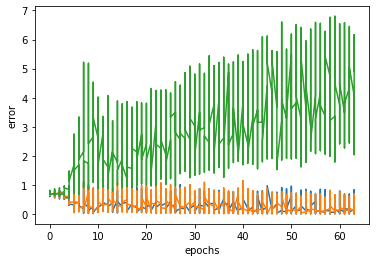

In [ ]:
plt.plot(epochs, d_fake_errs)
plt.plot(epochs, d_real_errs)
plt.plot(epochs, g_errs)
plt.xlabel("epochs")
plt.ylabel("error")

# Export to midi

In [ ]:
def raw3D_to_midi(array, name, precision=0.7):
    '''
    params:
      array : size 64,84,2 that represents the midi
      name: (str) of the midi file
      precision: threshold from where we suppose that the note is played/ 
    '''    
    
    
    pm = pretty_midi.PrettyMIDI()
    # Create an Instrument instance
    program = pretty_midi.instrument_name_to_program('Cello')
    piano = pretty_midi.Instrument(program=program)
    # array = tensor.cpu().detach().numpy()
    # def _round(x):
    #     if x < precision:
    #         return 0
    #     elif x > 1 - precision:
    #         return 1
    #     return x
    # array = np.array(list(map(lambda x: 0 if x < precision else 1, array)))

    # On choisi le statu de la note pour chaque note/temps
    # for i in range(len(array)):
    #   for j in range(len(array[i])):
    #     note_status = array[i][j]
    #     selected_status_index = np.argmax(note_status)
    #     for k in range(2):
    #       if k == selected_status_index:
    #         array[i][j][k] = 1
    #       else:
    #         array[i][j][k] = 0

    # for time_idx in range(64):
    #     for pitch_idx in range(84):
    #         if array[time_idx, pitch_idx] == 1:
    #             # note = pretty_midi.Note(
    #             # velocity=100, pitch=25 + pitch_idx, start=1 / 16 * time_idx, end=1 / 16 * (time_idx + 1))
    #             note = pretty_midi.Note(
    #             velocity=100, pitch=25 + pitch_idx, start=1 / 8 * time_idx, end=1 / 8 * (time_idx + 1))
    #             # Add it to our instrument
    #             piano.notes.append(note)


    for pitch_idx in range(84):
      for time_idx in range(64):
        is_played = array[time_idx, pitch_idx,0]
        if is_played > precision:
          # Means we played a new note
          end_gap = 1

          if not time_idx == 63:

            while array[time_idx+end_gap, pitch_idx,1] > precision and time_idx+end_gap < 63:
              end_gap += 1
          else:
            end_gap = 1
          note = pretty_midi.Note(
            velocity=100, pitch=25 + pitch_idx, start=1 / 8 * time_idx, end=(1 / 8) * (time_idx + end_gap))
          piano.notes.append(note)
          



    


    pm.instruments.append(piano)
    # Write out the MIDI data
    pm.write(f'midi_results/{name}.mid')

Pour récupérer les résultats créer un dossier "midi_results"

In [ ]:
test = landmark_seeds_data_list[-5][1][0]
test =  np.transpose(test, (0,2,3,1))


In [ ]:
raw3D_to_midi(test[0], "test")

In [ ]:
root_name = "jazzCNN_2D_"
for x in landmark_seeds_data_list:
  epoch_nb = x[0]
  data = x[1]
  for j in range(len(data)):
    reshaped_data = np.transpose(data[j], (0,2,3,1)).reshape(64,84,2)
    name = root_name + "epoch_" + str(epoch_nb) + "_seed" + str(j)
    raw3D_to_midi(reshaped_data, name, precision=0.7)

In [ ]:
!zip -r /content/results_jazzCNN2D_01.zip /content/midi_results

  adding: content/midi_results/ (stored 0%)
  adding: content/midi_results/jazzCNN_2D_epoch_60_seed7.mid (deflated 39%)
  adding: content/midi_results/jazzCNN_2D_epoch_30_seed1.mid (deflated 45%)
  adding: content/midi_results/jazzCNN_2D_epoch_40_seed4.mid (deflated 44%)
  adding: content/midi_results/jazzCNN_2D_epoch_10_seed0.mid (deflated 37%)
  adding: content/midi_results/jazzsample4.mid (deflated 19%)
  adding: content/midi_results/jazzCNN_2D_epoch_40_seed8.mid (deflated 38%)
  adding: content/midi_results/jazzCNN_2D_epoch_20_seed7.mid (deflated 45%)
  adding: content/midi_results/jazzCNN_2D_epoch_20_seed6.mid (deflated 36%)
  adding: content/midi_results/jazzCNN_2D_epoch_10_seed9.mid (deflated 45%)
  adding: content/midi_results/jazzCNN_2D_epoch_40_seed2.mid (deflated 38%)
  adding: content/midi_results/jazzCNN_2D_epoch_10_seed6.mid (deflated 19%)
  adding: content/midi_results/jazzCNN_2D_epoch_10_seed5.mid (deflated 32%)
  adding: content/midi_results/jazzCNN_2D_epoch_10_seed8.m

In [ ]:
from google.colab import files

In [ ]:
files.download('results_jazzCNN2D_01.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>